###  Custom Model with MobileNet as base model integrated with patch extraction and attention mechanisms

## Custom Model on Affectnet dataset

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Here, we are normalizing the pixel values to the range [0, 1]
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Set the batch size for the data generator
batch_size = 32

# Define the directories for the train, validation, and test sets
train_directory = '/kaggle/input/affectnet-dataset/AffectNet_train_test/train'
validation_directory = '/kaggle/input/affectnet-dataset/AffectNet_train_test/test'
test_directory = '/kaggle/input/affectnet-dataset/AffectNet_train_test/validation'

# Specify the class names explicitly as strings
class_names=['neutral', 'happy', 'sad', 'surprise', 'fear', 'disgust', 'anger']

# Create the image generators for the train, validation, and test sets
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 28732 images belonging to 7 classes.
Found 3500 images belonging to 7 classes.
Found 5071 images belonging to 7 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, Dense, GlobalAveragePooling2D, DepthwiseConv2D, Reshape, Activation, Concatenate
from tensorflow.keras.applications import MobileNet

def patch_extraction_block(x, num_patches):
    # A simple patch extraction block which uses convolutions with different kernel sizes
    patches = []
    for _ in range(num_patches):
        patch = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
        patch = BatchNormalization()(patch)
        patch = ReLU()(patch)
        patches.append(patch)
    # Concatenate all the patches together
    x = Concatenate()(patches)
    return x

def attention_block(x):
    # A simple attention mechanism with global average pooling and dense layers
    squeeze = GlobalAveragePooling2D()(x)
    squeeze = Dense(units=x.shape[-1] // 4, activation='relu')(squeeze)
    excitation = Dense(units=x.shape[-1], activation='sigmoid')(squeeze)
    excitation = Reshape((1, 1, -1))(excitation)
    scale = x * excitation
    return scale

# Load the MobileNet model pre-trained on ImageNet without the top layer
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Let's take an arbitrary intermediate layer as the starting point for customization.
x = base_model.output

# Patch extraction
x = patch_extraction_block(x, num_patches=3)  # Extract 3 patches

# Attention block
x = attention_block(x)

# Final operations for classification
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(7, activation='softmax')(x)  # Assuming 7 classes for FER

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                             

In [4]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50  # for example
)

Epoch 1/50
897/897 [==============================] - 259s 260ms/step - loss: 1.3247 - accuracy: 0.4970 - val_loss: 1.4947 - val_accuracy: 0.4688
Epoch 2/50
897/897 [==============================] - 76s 84ms/step - loss: 1.1160 - accuracy: 0.5799 - val_loss: 1.3564 - val_accuracy: 0.5278
Epoch 3/50
897/897 [==============================] - 76s 84ms/step - loss: 1.0163 - accuracy: 0.6182 - val_loss: 1.1654 - val_accuracy: 0.5722
Epoch 4/50
897/897 [==============================] - 76s 84ms/step - loss: 0.9185 - accuracy: 0.6625 - val_loss: 1.2626 - val_accuracy: 0.5502
Epoch 5/50
897/897 [==============================] - 76s 84ms/step - loss: 0.8190 - accuracy: 0.6987 - val_loss: 1.3834 - val_accuracy: 0.5321
Epoch 6/50
897/897 [==============================] - 76s 85ms/step - loss: 0.7053 - accuracy: 0.7407 - val_loss: 1.3191 - val_accuracy: 0.5585
Epoch 7/50
897/897 [==============================] - 75s 84ms/step - loss: 0.5951 - accuracy: 0.7821 - val_loss: 1.3747 - val_accurac

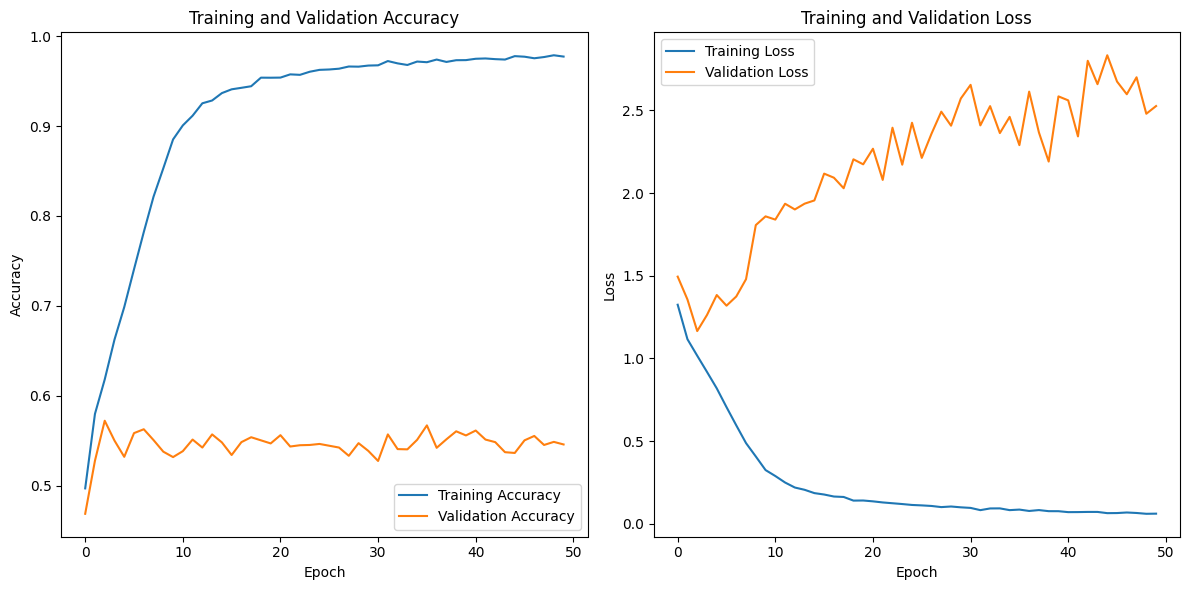

In [5]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

159/159 [==============================] - 44s 276ms/step
Confusion Matrix:
[[314  41 150  64  35  42 104]
 [ 58 574  24  29  11  33  21]
 [ 91  13 422  21  84  50  69]
 [ 71  57  38 354 165  32  33]
 [ 25  14  68  97 459  35  52]
 [ 21  19  63  17  49 284 118]
 [ 76  16  79  17  47  86 429]]


In [7]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


159/159 [==============================] - 10s 60ms/step
              precision    recall  f1-score   support

     neutral       0.48      0.42      0.45       750
       happy       0.78      0.77      0.77       750
         sad       0.50      0.56      0.53       750
    surprise       0.59      0.47      0.52       750
        fear       0.54      0.61      0.57       750
     disgust       0.51      0.50      0.50       571
       anger       0.52      0.57      0.54       750

    accuracy                           0.56      5071
   macro avg       0.56      0.56      0.56      5071
weighted avg       0.56      0.56      0.56      5071



In [8]:
# Save the best model as an .h5 file
model.save("patch_model.h5")  

##  Custom Model on RAF dataset

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Here, we are normalizing the pixel values to the range [0, 1]
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Set the batch size for the data generator
batch_size = 32

# Define the directories for the train, validation, and test sets
train_directory = '/kaggle/input/raf-ttv-dataset/RAF DB DATASET/train'
validation_directory = '/kaggle/input/raf-ttv-dataset/RAF DB DATASET/validation'
test_directory = '/kaggle/input/raf-ttv-dataset/RAF DB DATASET/test'

# Specify the class names explicitly as strings
class_names=['neutral', 'happy', 'sad', 'surprise', 'fear', 'disgust', 'angry']

# Create the image generators for the train, validation, and test sets
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

Found 10427 images belonging to 7 classes.
Found 1844 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, Dense, GlobalAveragePooling2D, DepthwiseConv2D, Reshape, Activation, Concatenate
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dropout  
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def patch_extraction_block(x, num_patches):
    # A simple patch extraction block which uses convolutions with different kernel sizes
    patches = []
    for _ in range(num_patches):
        patch = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
        patch = BatchNormalization()(patch)
        patch = ReLU()(patch)
        patches.append(patch)
    # Concatenate all the patches together
    x = Concatenate()(patches)
    return x

def attention_block(x):
    # A simple attention mechanism with global average pooling and dense layers
    squeeze = GlobalAveragePooling2D()(x)
    squeeze = Dense(units=x.shape[-1] // 4, activation='relu')(squeeze)
    excitation = Dense(units=x.shape[-1], activation='sigmoid')(squeeze)
    excitation = Reshape((1, 1, -1))(excitation)
    scale = x * excitation
    return scale

# Load the MobileNet model pre-trained on ImageNet without the top layer
base_model = MobileNet(input_shape=(100, 100, 3), include_top=False, weights='imagenet')

# Let's take an arbitrary intermediate layer as the starting point for customization.
x = base_model.output

# Patch extraction
x = patch_extraction_block(x, num_patches=3)  # Extract 3 patches

# Attention block
x = attention_block(x)

# Final operations for classification
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) 
x = Dense(1024, activation='relu')(x)
x = Dense(7, activation='softmax')(x)  # Assuming 7 classes for FER

# Create the model
model = Model(inputs=base_model.input, outputs=x)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the highest validation accuracy.
)

# Initialize model checkpoint to save the model with the best validation accuracy.
model_checkpoint = ModelCheckpoint(
    'mobilenet_raf.h5',  # The path where to save the model
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True  # The latest best model according to the quantity monitored will not be overwritten.
)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_3[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['conv1_bn[0][0]']         

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50  # for example
)

Epoch 1/50
325/325 [==============================] - 56s 119ms/step - loss: 1.0072 - accuracy: 0.6504 - val_loss: 1.0580 - val_accuracy: 0.6371
Epoch 2/50
325/325 [==============================] - 14s 44ms/step - loss: 0.7234 - accuracy: 0.7524 - val_loss: 0.6685 - val_accuracy: 0.7780
Epoch 3/50
325/325 [==============================] - 14s 44ms/step - loss: 0.5807 - accuracy: 0.8071 - val_loss: 1.0315 - val_accuracy: 0.7368
Epoch 4/50
325/325 [==============================] - 14s 44ms/step - loss: 0.4598 - accuracy: 0.8453 - val_loss: 0.6556 - val_accuracy: 0.7818
Epoch 5/50
325/325 [==============================] - 15s 45ms/step - loss: 0.3806 - accuracy: 0.8729 - val_loss: 0.6268 - val_accuracy: 0.8054
Epoch 6/50
325/325 [==============================] - 15s 45ms/step - loss: 0.3112 - accuracy: 0.8992 - val_loss: 0.6999 - val_accuracy: 0.7900
Epoch 7/50
325/325 [==============================] - 14s 44ms/step - loss: 0.2430 - accuracy: 0.9209 - val_loss: 0.8357 - val_accuracy

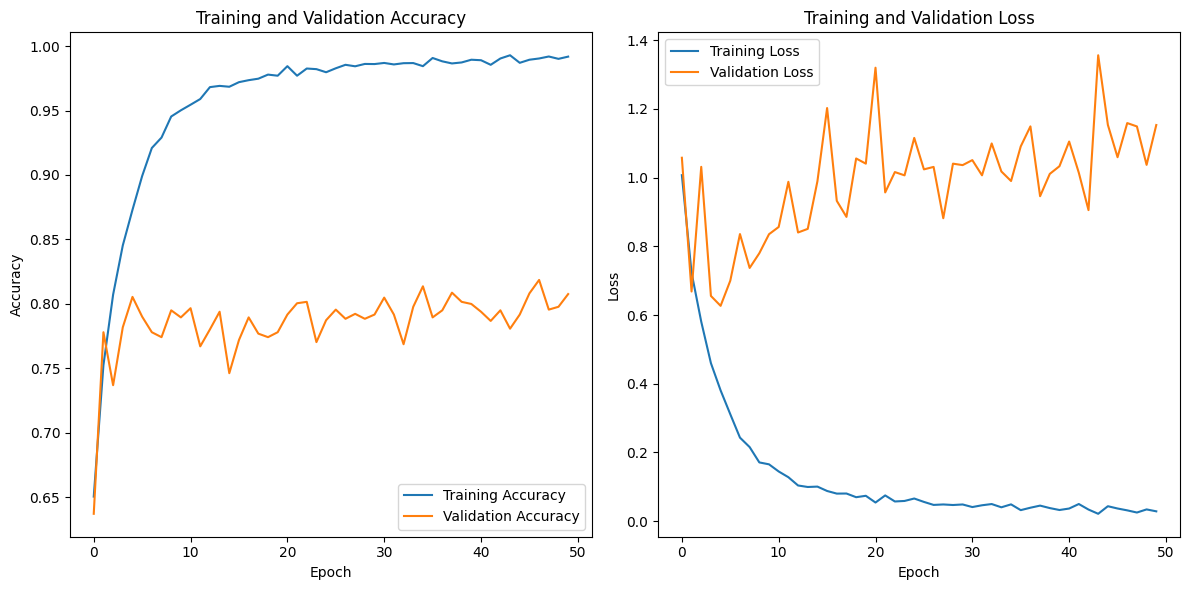

In [13]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

96/96 [==============================] - 16s 166ms/step
Confusion Matrix:
[[ 572   26   44   16    0   19    3]
 [  53 1094   11    5    2   11    9]
 [  53   32  352    5    4   22   10]
 [  28   15    9  247    5    9   16]
 [   4    6    7   11   37    2    7]
 [  34   15   13    3    1   78   16]
 [  11    8    4    4    2   18  115]]


In [15]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


96/96 [==============================] - 3s 36ms/step
              precision    recall  f1-score   support

     neutral       0.76      0.84      0.80       680
       happy       0.91      0.92      0.92      1185
         sad       0.80      0.74      0.77       478
    surprise       0.85      0.75      0.80       329
        fear       0.73      0.50      0.59        74
     disgust       0.49      0.49      0.49       160
       angry       0.65      0.71      0.68       162

    accuracy                           0.81      3068
   macro avg       0.74      0.71      0.72      3068
weighted avg       0.81      0.81      0.81      3068



In [16]:
# Save the best model as an .h5 file
model.save("patch_model_raf.h5")  

# Feature Maps

1/1 [==============================] - 0s 100ms/step


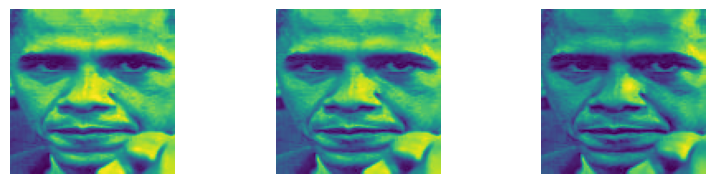

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Assuming `model` is your pre-trained model.

# Extract the outputs of the top layers you want to visualize
layer_outputs = [layer.output for layer in model.layers[:8]]  # You can change the range as needed

# Create a model for displaying the feature maps
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Path to the image file
img_path = '/kaggle/input/raf-ttv-dataset/RAF DB DATASET/test/angry/test_0017_aligned.jpg'

# Load the image with the target size of your model
img = image.load_img(img_path, target_size=(100, 100))

# Convert the image to a numpy array
img_tensor = image.img_to_array(img)

# Expand dimensions to fit the model's expected input
img_tensor = np.expand_dims(img_tensor, axis=0)

# Preprocess the image according to the needs of the model
# MobileNet expects pixel values between [-1, 1] or [0, 1], adjust accordingly
img_tensor /= 255.  # If needed, use the specific preprocessing for MobileNet here

# Get the feature maps for the input image
activations = activation_model.predict(img_tensor)

# Visualize the feature maps
first_layer_activation = activations[0]
plt.figure(figsize=(20, 15))
for i in range(first_layer_activation.shape[-1]):
    plt.subplot(6, 6, i + 1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()


1/1 [==============================] - 0s 114ms/step


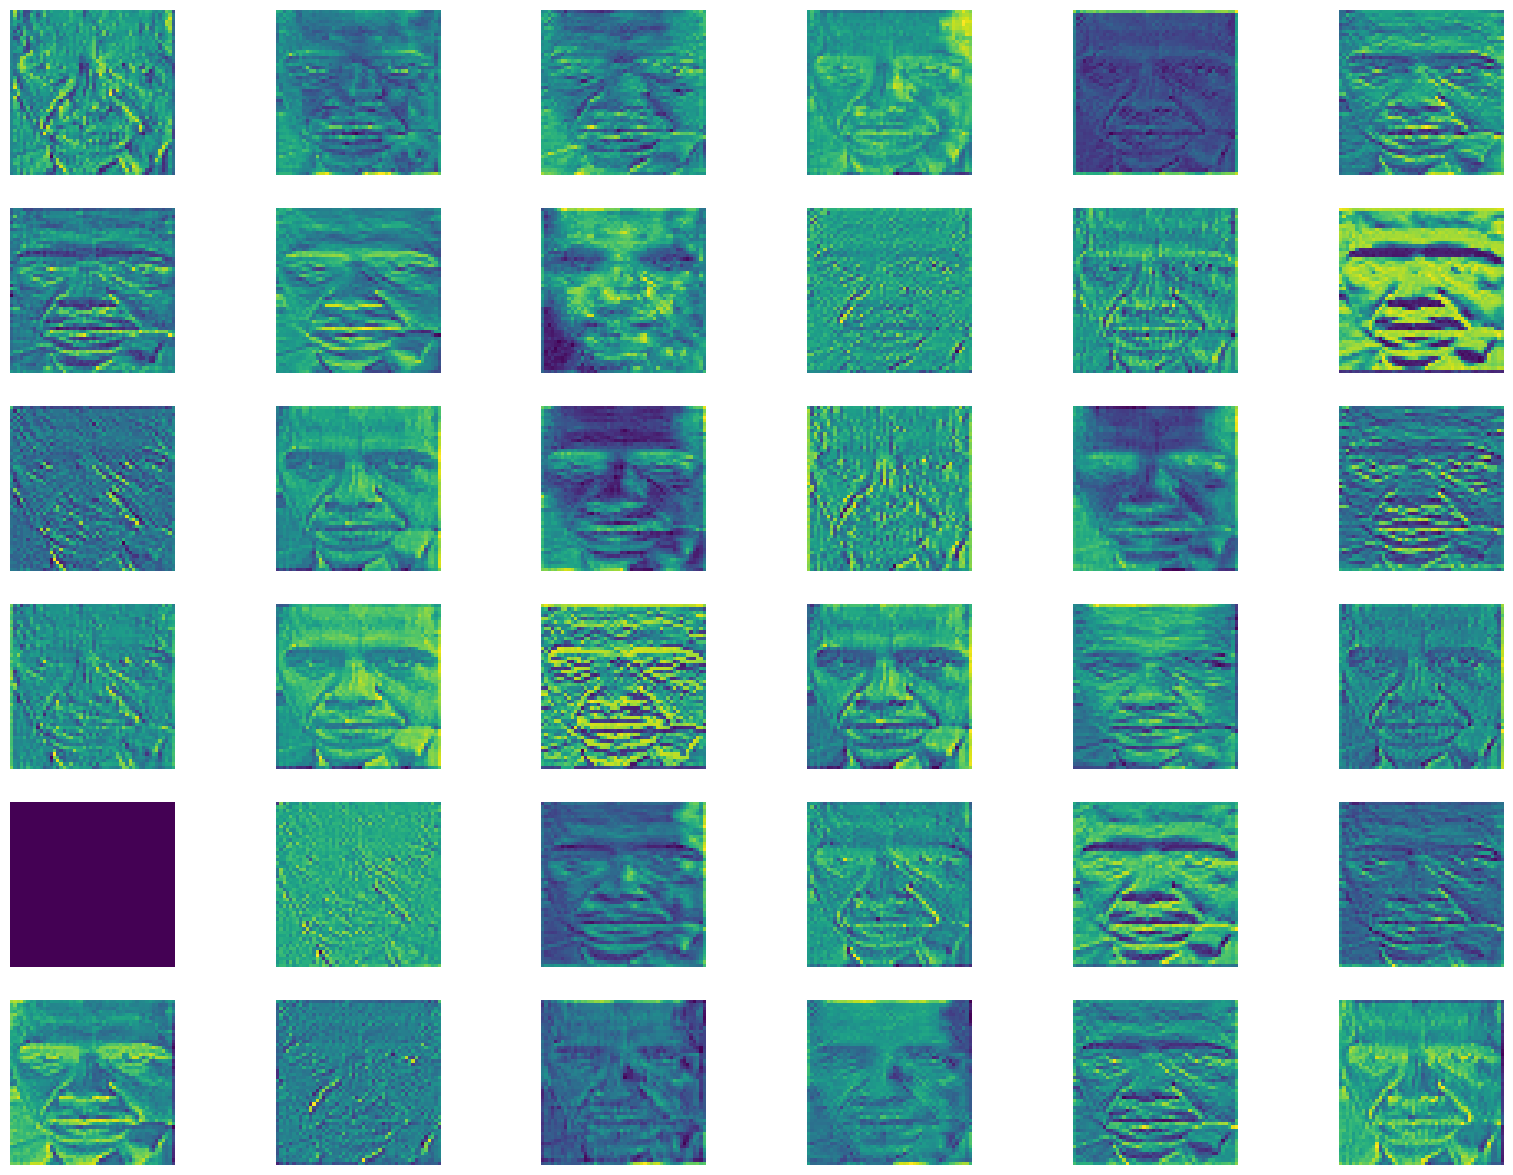

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Assuming `model` is your pre-trained model.

# Extract the outputs of the top layers you want to visualize
layer_outputs = [layer.output for layer in model.layers[8:16]]  # Extract to deeper layers

# Create a model for displaying the feature maps
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Path to the image file
img_path = '/kaggle/input/raf-ttv-dataset/RAF DB DATASET/test/angry/test_0017_aligned.jpg'

# Load the image with the target size of your model
img = image.load_img(img_path, target_size=(100, 100))

# Convert the image to a numpy array
img_tensor = image.img_to_array(img)

# Expand dimensions to fit the model's expected input
img_tensor = np.expand_dims(img_tensor, axis=0)

# Preprocess the image according to the needs of the model
# MobileNet expects pixel values between [-1, 1] or [0, 1], adjust accordingly
img_tensor /= 255.  # If needed, use the specific preprocessing for MobileNet here

# Get the feature maps for the input image
activations = activation_model.predict(img_tensor)

# Visualize the feature maps
first_layer_activation = activations[0]
plt.figure(figsize=(20, 15))
# Now, change the range to plot only the first 36 feature maps
num_features = first_layer_activation.shape[-1]
num_features_to_plot = min(num_features, 36)  # Plot only the first 36 features
for i in range(num_features_to_plot):
    plt.subplot(6, 6, i + 1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()


# Grad CAM

1/1 [==============================] - 0s 24ms/step


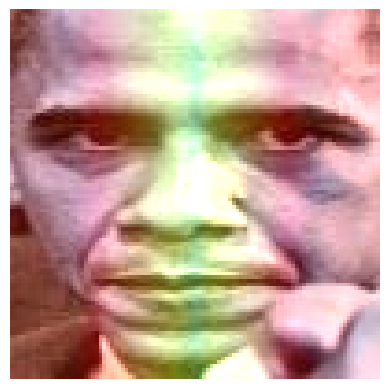

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import cv2

# The local path to our target image
img_path = '/kaggle/input/raf-ttv-dataset/RAF DB DATASET/test/angry/test_0017_aligned.jpg'

# Load the image for display
img = load_img(img_path, target_size=(100, 100))

# Preprocess the image for model prediction
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

# Prepare the image according to MobileNet requirements
img_batch = preprocess_input(img_batch)

# Assuming 'model' is your trained model that you have loaded already.
# Get model predictions
preds = model.predict(img_batch)

# Get the index of the max class predicted (if your model uses softmax)
argmax = np.argmax(preds[0])

# Name of the last convolutional layer 
last_conv_layer_name = 'conv_pw_13_relu'  
last_conv_layer = model.get_layer(last_conv_layer_name)

# Create a model with the input of the original model and outputs of the last convolutional layer
grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

# Record operations for automatic differentiation
with tf.GradientTape() as tape:
    # Cast the image tensor to a float-32 tensor
    inputs = tf.cast(img_batch, tf.float32)
    # Tape the gradient of the output predictions with respect to the conv layer outputs
    tape.watch(inputs)
    conv_outputs, predictions = grad_model(inputs)
    loss = predictions[:, argmax]

# Extract the gradients and average them along the axes
grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Multiply each channel in the feature map array by the importance weights
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Apply ReLU and normalize the heatmap
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Ensure the heatmap is a NumPy array
heatmap = np.array(heatmap)

# Prepare the image
# 'img' is redefined as a PIL Image object, we should convert it to a NumPy array
img = cv2.imread(img_path)
img = cv2.resize(img, (100, 100))

# Convert the heatmap to NumPy array if it's not already
heatmap = np.array(heatmap)

# Resize the heatmap to the size of the original image
# Use the 'img' NumPy array to get the shape
heatmap_size = (img.shape[1], img.shape[0])  # Width (cv2 uses width x height), Height
heatmap = cv2.resize(heatmap, heatmap_size)

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = heatmap * 0.4 + img
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()



1/1 [==============================] - 0s 23ms/step


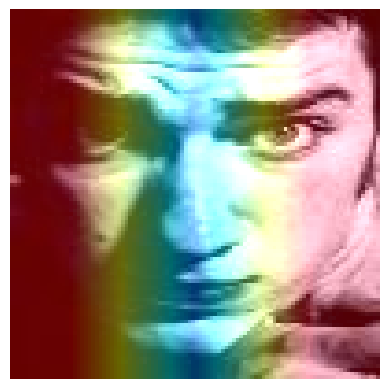

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import cv2

# The local path to our target image
img_path = '/kaggle/input/raf-ttv-dataset/RAF DB DATASET/test/fear/test_0377_aligned.jpg'

# Load the image for display
img = load_img(img_path, target_size=(100, 100))

# Preprocess the image for model prediction
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

# Prepare the image according to MobileNet requirements
img_batch = preprocess_input(img_batch)

# Assuming 'model' is your trained model that you have loaded already.
# Get model predictions
preds = model.predict(img_batch)

# Get the index of the max class predicted (if your model uses softmax)
argmax = np.argmax(preds[0])

# Name of the last convolutional layer 
last_conv_layer_name = 'conv_pw_13_relu'  
last_conv_layer = model.get_layer(last_conv_layer_name)

# Create a model with the input of the original model and outputs of the last convolutional layer
grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

# Record operations for automatic differentiation
with tf.GradientTape() as tape:
    # Cast the image tensor to a float-32 tensor
    inputs = tf.cast(img_batch, tf.float32)
    # Tape the gradient of the output predictions with respect to the conv layer outputs
    tape.watch(inputs)
    conv_outputs, predictions = grad_model(inputs)
    loss = predictions[:, argmax]

# Extract the gradients and average them along the axes
grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Multiply each channel in the feature map array by the importance weights
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Apply ReLU and normalize the heatmap
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Ensure the heatmap is a NumPy array
heatmap = np.array(heatmap)

# Prepare the image
# 'img' is redefined as a PIL Image object, we should convert it to a NumPy array
img = cv2.imread(img_path)
img = cv2.resize(img, (100, 100))

# Convert the heatmap to NumPy array if it's not already
heatmap = np.array(heatmap)

# Resize the heatmap to the size of the original image
# Use the 'img' NumPy array to get the shape
heatmap_size = (img.shape[1], img.shape[0])  # Width (cv2 uses width x height), Height
heatmap = cv2.resize(heatmap, heatmap_size)

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = heatmap * 0.4 + img
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()



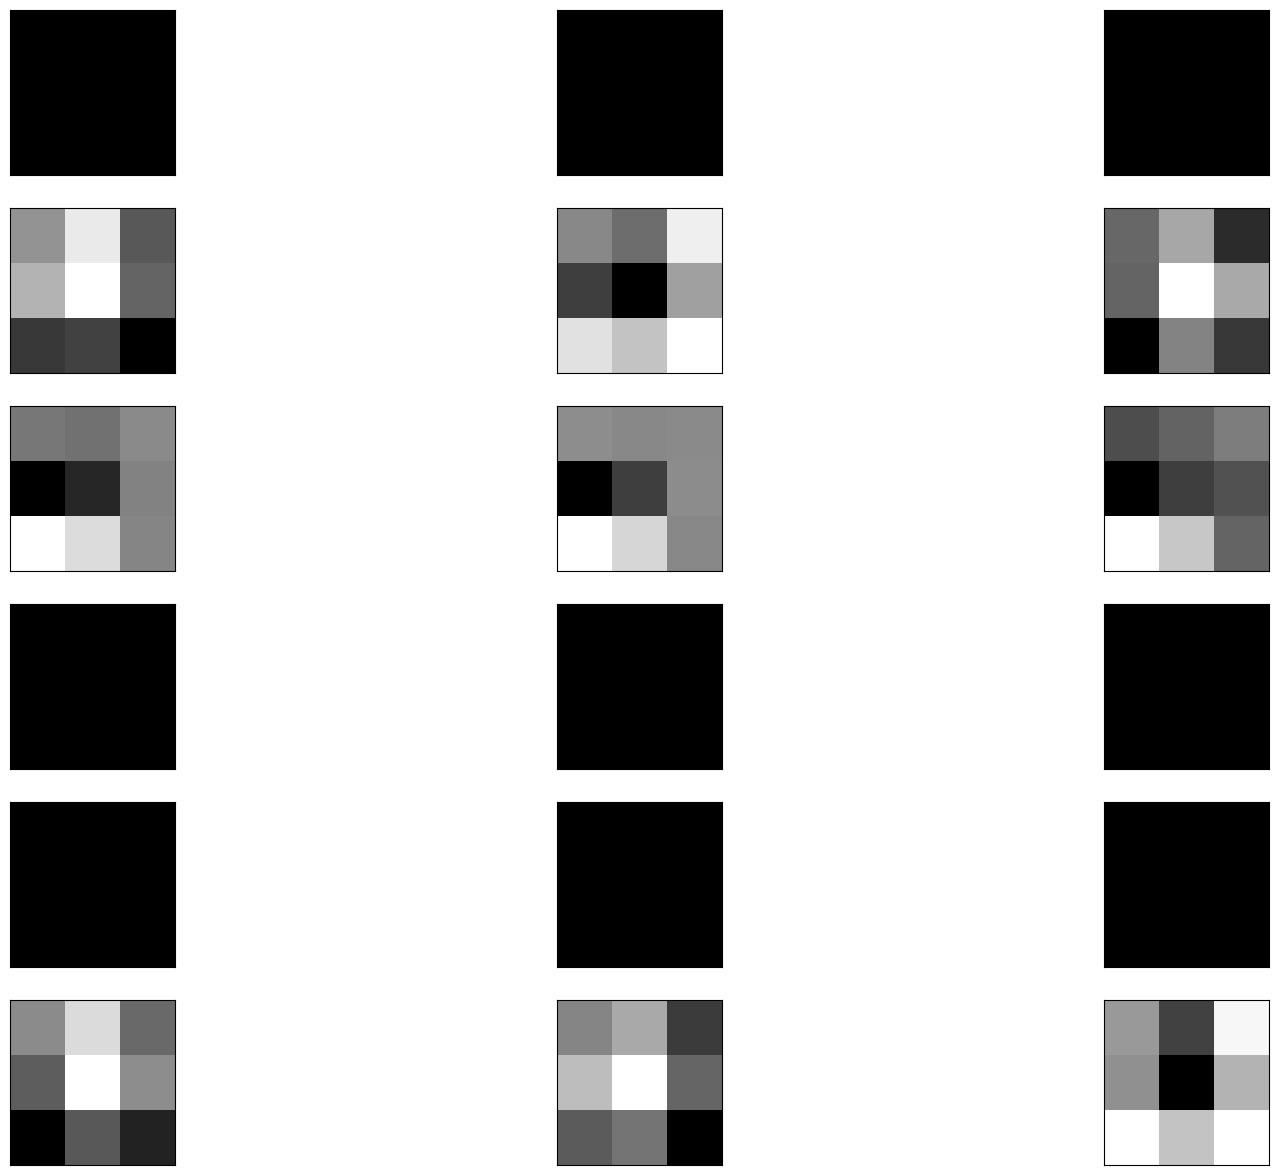

In [30]:
# Name of the first convolutional layer
first_layer_name = 'conv1'  # Replace with your actual layer name
first_conv_layer = model.get_layer(first_layer_name)

# Get the weights of the first conv layer (assuming no biases)
weights = first_conv_layer.get_weights()[0]

# Normalize filter values to 0-1 so we can visualize them
f_min, f_max = weights.min(), weights.max()
filters = (weights - f_min) / (f_max - f_min)

# Plot first few filters
n_filters, ix = 6, 1
plt.figure(figsize=(20,15))
for i in range(n_filters):
    # Get the filter
    f = filters[:, :, :, i]
    # Plot each channel separately
    for j in range(3):  # assuming color channels are the last dimension in your filter
        # Specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # Plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# Show the figure
plt.show()


## Custom Model on FER2013 dataset

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Here, we are normalizing the pixel values to the range [0, 1]
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Set the batch size for the data generator
batch_size = 32

# Define the directories for the train, validation, and test sets
train_directory = '/kaggle/input/fec-ba/FEC_BA_train_test_validation/train'
validation_directory = '/kaggle/input/fec-ba/FEC_BA_train_test_validation/validation'
test_directory = '/kaggle/input/fec-ba/FEC_BA_train_test_validation/test'

# Specify the class names explicitly as strings
class_names = ['angry','disgust','fear','happy','neutral','sad','surprise']

# Create the image generators for the train, validation, and test sets
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)


Found 24399 images belonging to 7 classes.
Found 4310 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, ReLU, BatchNormalization, Add, Dense, GlobalAveragePooling2D, DepthwiseConv2D, Reshape, Activation, Concatenate
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def patch_extraction_block(x, num_patches):
    # A simple patch extraction block which uses convolutions with different kernel sizes
    patches = []
    for _ in range(num_patches):
        patch = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
        patch = BatchNormalization()(patch)
        patch = ReLU()(patch)
        patches.append(patch)
    # Concatenate all the patches together
    x = Concatenate()(patches)
    return x

def attention_block(x):
    # A simple attention mechanism with global average pooling and dense layers
    squeeze = GlobalAveragePooling2D()(x)
    squeeze = Dense(units=x.shape[-1] // 4, activation='relu')(squeeze)
    excitation = Dense(units=x.shape[-1], activation='sigmoid')(squeeze)
    excitation = Reshape((1, 1, -1))(excitation)
    scale = x * excitation
    return scale

input_shape = (48, 48, 1)  # Grayscale image shape
input_tensor = Input(shape=input_shape)

# Lambda layer to repeat the single-channel grayscale image to three channels
x = Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1))(input_tensor)

# Load the MobileNet model pre-trained on ImageNet without the top layer
# Make sure to not include the top and provide the correct input_tensor
base_model = MobileNet(include_top=False, weights='imagenet', input_tensor=x)

# Let's take an arbitrary intermediate layer as the starting point for customization.
x = base_model.output

# Patch extraction
x = patch_extraction_block(x, num_patches=3)  # Extract 3 patches

# Attention block
x = attention_block(x)

# Final operations for classification
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(7, activation='softmax')(x)  # Assuming 7 classes for FER

# Create the model
model = Model(inputs=input_tensor, outputs=x)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the highest validation accuracy.
)

# Initialize model checkpoint to save the model with the best validation accuracy.
model_checkpoint = ModelCheckpoint(
    'mobilenet_raf.h5',  # The path where to save the model
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True  # The latest best model according to the quantity monitored will not be overwritten.
)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 48, 48, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 32)   864         ['lambda[0][0]']                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 32)   128         ['conv1[0][0]']                  
                                                                                           

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50  # for example
)

Epoch 1/50
762/762 [==============================] - 99s 107ms/step - loss: 1.4198 - accuracy: 0.4587 - val_loss: 1.2969 - val_accuracy: 0.5007
Epoch 2/50
762/762 [==============================] - 28s 36ms/step - loss: 1.2358 - accuracy: 0.5418 - val_loss: 1.1928 - val_accuracy: 0.5459
Epoch 3/50
762/762 [==============================] - 29s 38ms/step - loss: 1.1417 - accuracy: 0.5781 - val_loss: 1.1432 - val_accuracy: 0.5707
Epoch 4/50
762/762 [==============================] - 31s 41ms/step - loss: 1.0623 - accuracy: 0.6114 - val_loss: 1.1369 - val_accuracy: 0.5723
Epoch 5/50
762/762 [==============================] - 31s 41ms/step - loss: 0.9991 - accuracy: 0.6336 - val_loss: 1.2257 - val_accuracy: 0.5522
Epoch 6/50
762/762 [==============================] - 30s 40ms/step - loss: 0.9187 - accuracy: 0.6615 - val_loss: 1.1824 - val_accuracy: 0.5518
Epoch 7/50
762/762 [==============================] - 29s 38ms/step - loss: 0.8577 - accuracy: 0.6896 - val_loss: 1.1638 - val_accuracy

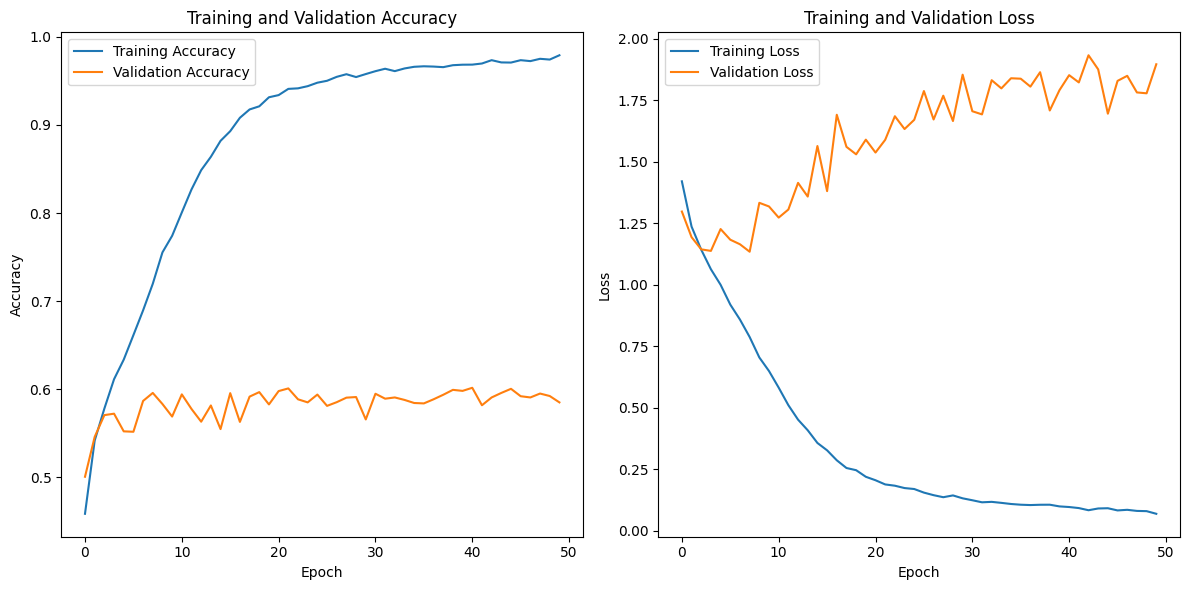

In [35]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

225/225 [==============================] - 37s 164ms/step
Confusion Matrix:
[[ 504   13  128   58   77  134   44]
 [  34   48   11    4    5    7    2]
 [ 143    4  430   42   82  186  137]
 [  64    0   64 1429   90   55   72]
 [ 154    1  120  108  595  219   36]
 [ 177    3  224   72  151  579   41]
 [  30    1   60   31   21   18  670]]


In [37]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


225/225 [==============================] - 7s 29ms/step
              precision    recall  f1-score   support

       angry       0.46      0.53      0.49       958
     disgust       0.69      0.43      0.53       111
        fear       0.41      0.42      0.42      1024
       happy       0.82      0.81      0.81      1774
     neutral       0.58      0.48      0.53      1233
         sad       0.48      0.46      0.47      1247
    surprise       0.67      0.81      0.73       831

    accuracy                           0.59      7178
   macro avg       0.59      0.56      0.57      7178
weighted avg       0.59      0.59      0.59      7178



In [38]:
# Save the best model as an .h5 file
model.save("patch_model_fer.h5")  